In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
import numpy as np
from statsmodels.tsa.stattools import adfuller, pacf_yw, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults 
from pandas.plotting import lag_plot
from datetime import timedelta,datetime

## Checking for missing dates in the data

In [2]:
### This function looks for missing data, OPEN any file using this function 
def file(file_name):
    data = pd.read_csv(file_name)
    time = []
    price = []
    missing_dates = []
    
    for i in range(len(data)):
        my_data = pd.to_datetime(data['Date'][i])
        time.append(my_data)
        price.append(data['Close'][i])
        
    ## generates dates from x to y so that I can use the length of array to figure out
    ## if there are any dates missing in the data set obtained from Yahoo Finance
    generate = pd.date_range(start = time[0],end= time[len(time)-1])
    #print(type(generate[0]))
    
    ## checks whether I have complete data or any dates missing
    if len(data) == len(generate):
        data.set_index('Date', inplace=True)
        print('the original data set has no gaps')
        return data
    else:
        j = 1
        while j < len(generate):
            ## generates the next date from the previous date
            next_day = pd.to_datetime(time[j-1]) + timedelta(days = 1)
            if time[j] != next_day:
                missing_dates.append(next_day)           ## keeps track of missing dates
                price.insert(j,(price[j-1]+price[j])/2 ) ## adding midpoint of prices for the missing dates
                time.insert(j, next_day)                 ## adding missing time
                j+=1
            else:
                j+=1
    
    #print(missing_dates)
    dataframe = pd.DataFrame({'Date':time, 'Close':price})
    dataframe.set_index('Date', inplace=True)
    
    return dataframe


In [3]:
file('TSLA.csv')

Close
Date                  
2015-07-10   51.830002
2015-07-11   52.131000
2015-07-12   52.281500
2015-07-13   52.431999
2015-07-14   53.130001
...                ...
2020-07-05  270.243008
2020-07-06  274.316010
2020-07-07  277.971985
2020-07-08  273.175995
2020-07-09  278.855988

[1827 rows x 1 columns]

## Opening files, not checking for missing dates

In [4]:
#### Opening file this way does NOT account for missing data
##kaggle data
#data = pd.read_csv(r'C:\Users\asfia\Downloads\upload_DJIA_table.csv',index_col ="Date", parse_dates = True)
#data_rev = pd.DataFrame.reset_index(data.loc[::-1])
#data_rev.head()
#data_rev.drop('index', axis = 1)

## tesla stock from 10/07/2015 to 09/07/2020
tesla = pd.read_csv(r'C:\Users\asfia\Downloads\TSLA.csv',index_col ="Date", parse_dates = True)
#tesla.head()

In [5]:
## Apple stock data from 29/06/2010 to 09/02/2022, Founded 1 April 1976
apple = pd.read_csv(r'C:\Users\asfia\Downloads\AAPL.csv',index_col ="Date", parse_dates = True)
#apple.head()

## Amazon stock from 29/06/2010 to 09/02/2022, Founded 5 July 1994
amazon = pd.read_csv(r'C:\Users\asfia\Downloads\AMZN.csv',index_col ="Date", parse_dates = True)

## google stock from 29/06/2010 to 09/02/2022, Founded 4 September 1998
google = pd.read_csv(r'C:\Users\asfia\Downloads\GOOG.csv',index_col ="Date", parse_dates = True)

## Max tesla from 29/06/2010 to 09/02/2022, Founded 1 July 2003
max_tesla = pd.read_csv(r'C:\Users\asfia\Downloads\MAX TSLA.csv',index_col ="Date", parse_dates = True)
print(max(max_tesla['Close'][:int(len(max_tesla)*0.8)]), min(max_tesla['Close'][:int(len(max_tesla)*0.8)]))

77.0 3.16


Text(0, 0.5, 'price')

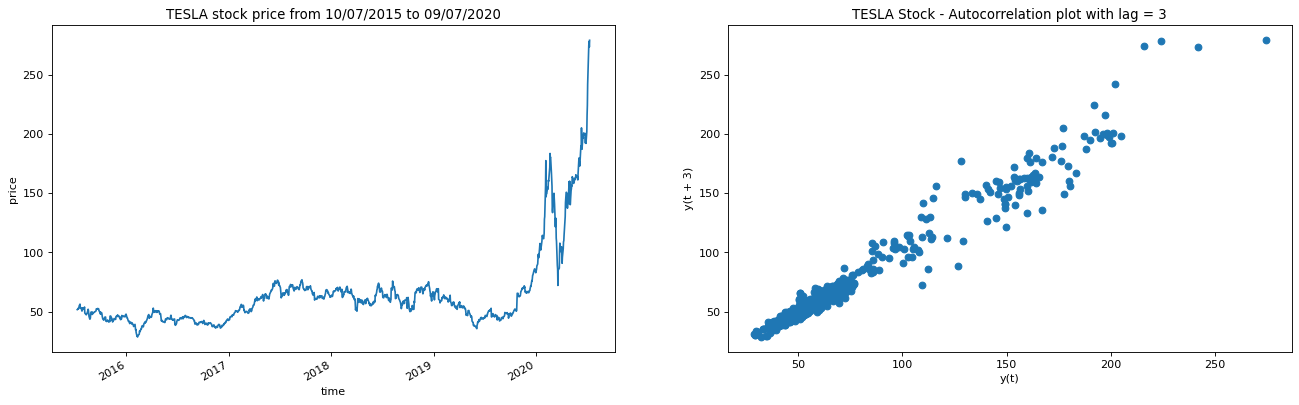

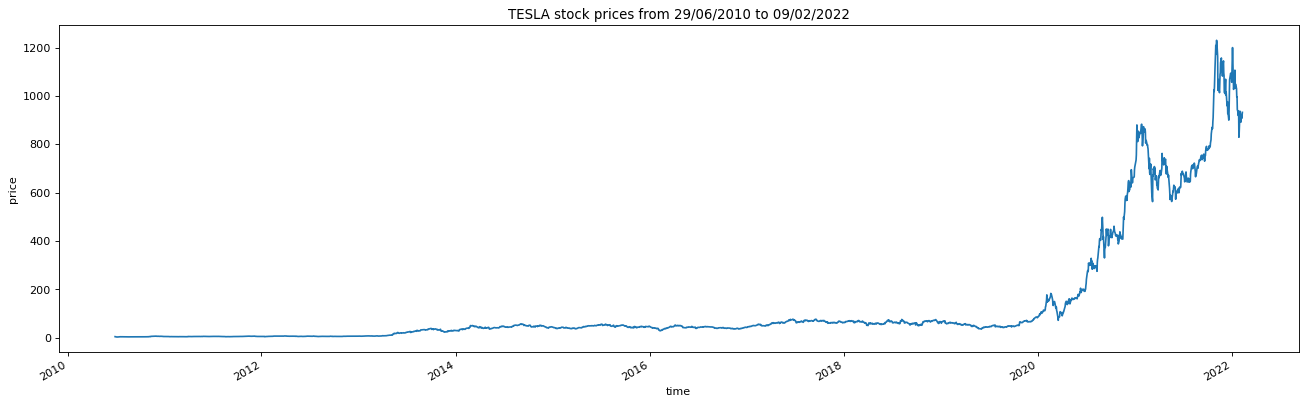

In [6]:
plt.figure(figsize = (20, 6), dpi = 80)
plt.subplot(1,2,1)
tesla['Close'].plot()
#plt.xticks(np.arange(0,1259, 200), tesla['Date'][0:1259:200])
plt.title("TESLA stock price from 10/07/2015 to 09/07/2020")
plt.xlabel("time")
plt.ylabel("price")
plt.subplot(1,2,2)
lag_plot(tesla['Close'], lag=3)
plt.title('TESLA Stock - Autocorrelation plot with lag = 3')
plt.figure(figsize = (20, 6), dpi = 80)
max_tesla['Close'].plot()
plt.title("TESLA stock prices from 29/06/2010 to 09/02/2022")
plt.xlabel("time")
plt.ylabel("price")

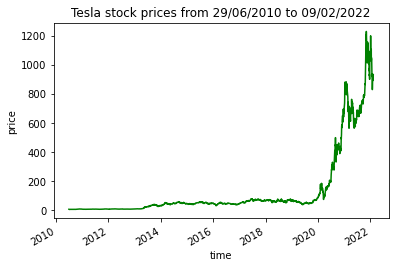

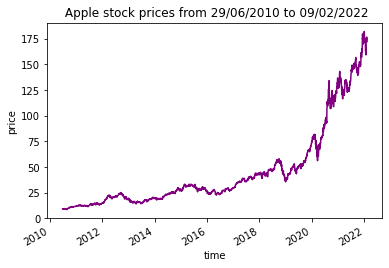

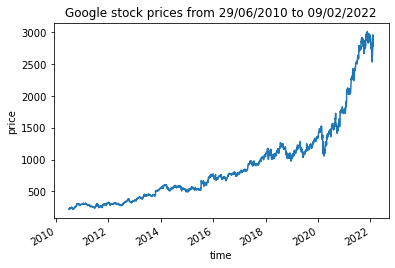

In [7]:
#plt.figure(figsize = (20, 8), dpi = 100)
max_tesla['Close'].plot(color="green")
plt.title("Tesla stock prices from 29/06/2010 to 09/02/2022")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

apple['Close'].plot(color="purple")
plt.title(" Apple stock prices from 29/06/2010 to 09/02/2022")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

google['Close'].plot()
plt.title("Google stock prices from 29/06/2010 to 09/02/2022")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

## This code zooms into certain dates 

In [8]:
## frequency dictates the interval at which stock price is predicted i.e. monthly/ daily/ Annually
## frequency only accepts string (lowercase letter): Monthly = 'm', Daily = 'd', Annually = 'a'
## period is the number of days/months/years the data should be plotted/ predicted for
## depending on the value given for period, the data will be equally divided and plotted in subplots
## for data enter name_of_file
## monthly 4*30
##4*12
##4*1

def zoom_in(data,freq,period,p):
    if freq == 'm':
        t = int(period*30)
    elif freq == 'd':
        t = int(period*1)
    else:
        t = int(period*12)
        
    remainder = len(data) % t
    even_list = len(data) - remainder ## making the list even numbered
    num_of_graphs = int(even_list/t)
    j = 0 
    for i in range(num_of_graphs):
        j += t
        slice_data = data[j-t:j].plot()
        #plt.title('{},{}'.format(data.index[j-t],data.index[j]))
        print(data.index[j-t], data.index[j])
        plt.show()
    if remainder > 0:
        extra = data[even_list:len(data)]
        print(extra.index[0], extra.index[len(extra)-1])
        extra.plot()
        plt.show()
    else:
        return None  

In [9]:
#u = zoom_in(tesla['Close'],'m',12,tesla)

## Auto Arima

### real version
def AutoArima(train,test):
    model = auto_arima(train['Close'],trace = True, error_action = 'warn',suppress_warning = False)

    prediction_test = model.predict(n_periods = len(test))
    prediction_test = pd.DataFrame(prediction_test,index = test.index, columns = ['Prediction'])
    train['Close'].plot(x = 'Date', y = 'Close', label = 'train')
    test ['Close'].plot(x = 'Date', y = 'Close', label = 'test' )
    #tesla['Close'][0:1100].plot()
    plt.plot(prediction_test, label='Prediction')
    plt.legend()
    return None 

In [10]:
def AutoArima(train,test, name):
    model = auto_arima(train['Close'],trace = True, error_action = 'ignore',suppress_warning = True,stepwise=False)

    fc, conf_int  = model.predict(len(test),return_conf_int=True,alpha=0.05)
    
    train['Close'].plot(x = 'Date', ylabel = 'Closing prices', label = 'train')
    test ['Close'].plot(x = 'Date', y = 'Closing prices', label = 'test')
    #plt.title('Predicting stock prices using Auto ARIMA for the test set')
    
    plt.plot(test.index, fc, label = 'prediction')
    
    
    #dataframe = pd.DataFrame({'Date':test.index, 'Predicted prices':fc, 'Original prices': test['Close']})
    #dataframe.set_index('Date', inplace=True)
    conf_int_lower = []
    conf_int_upper = []
    for i in range(0,len(conf_int)):
        conf_int_lower.append(conf_int[i][0])
        conf_int_upper.append(conf_int[i][1])
        
    plt.fill_between(test.index, conf_int_upper, conf_int_lower, color='blue', alpha=0.05, label = '95% confidence interval')
    plt.title('Forecasting the prices for {} test set from {} to 09/02/2022'. format(name,test.index[0].strftime('%d/%m/%Y')))
    plt.legend()
    
    return None

## 1 year tesla

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1900.022, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1901.920, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1903.289, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1902.559, Time=0.23 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1904.478, Time=0.33 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1906.470, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1901.909, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1903.852, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1903.977, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1904.494, Time=0.40 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1906.477, Time=0.52 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1903.396, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1904.348, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(3,1,0)(0,0,0)

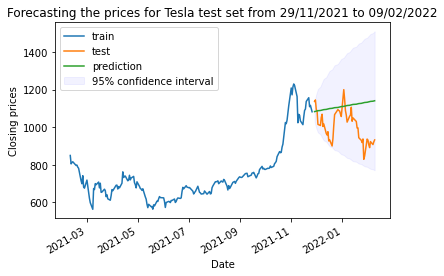

In [11]:
cut_max_tsla = max_tesla[2672:len(max_tesla)]  ### 09/02/2021 to 09/02/2022, 1 year
AutoArima(cut_max_tsla[:int(len(cut_max_tsla)*0.8)],cut_max_tsla[int(len(cut_max_tsla)*0.8):],'Tesla')

## 6 months Tesla

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1019.646, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1021.293, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1023.176, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1025.154, Time=0.21 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1026.056, Time=0.25 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1023.257, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1021.270, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1023.163, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1025.173, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1024.083, Time=0.29 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1024.988, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1023.182, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1025.179, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1022.375, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(3,1,0)(0

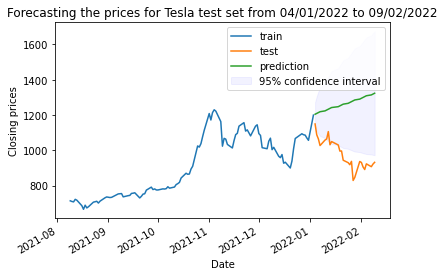

In [12]:
six_month =  max_tesla[2797:len(max_tesla)]   ### 09/08/2021 to 09/02/2022, 6 months 
AutoArima(six_month[:int(len(six_month)*0.8)],six_month[int(len(six_month)*0.8):],'Tesla')
#plt.title('Predicting stock prices using Auto ARIMA for the Tesla test set')

def Final_AutoArima(file,train,test,day):
    model = auto_arima(train['Close'],start_p =0, start_d=0, start_q = 0, max_p= 3, max_d=3, max_q = 3,D=1,trace = True, error_action = 'ignore',suppress_warning = True,stepwise=False,seasonal=True)
    prediction = model.predict(n_periods = day)
    #print(len(prediction))
    
    pred_dates = pd.date_range(start = file.index[len(file)-1],  end = file.index[len(file)-2] + timedelta(days = day),freq='D')
    print(len(pred_dates))
    file['Close'].plot()
    plt.plot(pred_dates, prediction)
    #dataframe = pd.DataFrame({'Date':pred_dates, 'Close':prediction})
    
    #print(len(pred_dates))
    train['Close'].plot(x = 'Date', y = 'Close', label = 'train')
    test ['Close'].plot(x = 'Date', y = 'Close', label = 'test' )
    
    return None 

def Final_AutoArima(file, day):
    model = auto_arima(file['Close'], p=0, d=1, q=0, trace = True, error_action = 'ignore',suppress_warning = True,stepwise=False)
    
    pred_dates = pd.date_range(start = file.index[len(file)-1],  end = file.index[len(file)-1] + timedelta(days = day),freq='D')
    file['Close'].plot()
    
    fc, conf_int  = model.predict(day+1,return_conf_int=True,alpha=0.05)

    plt.plot(pred_dates, fc)
    plt.plot(pred_dates, conf_int)

    return None 

#cut_data = tesla[0:1111] ## cut out the spike in tesla
#AutoArima(cut_data[:int(len(cut_data)*0.5)],cut_data[int(len(cut_data)*0.5):]) 
Final_AutoArima(max_tesla,100)

## Apple Auto-arima 1 year

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=849.329, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=850.756, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=852.748, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=853.211, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=849.923, Time=0.20 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=851.157, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=850.759, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=847.541, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=849.327, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=849.096, Time=0.27 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=849.927, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=852.759, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=854.675, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=848.746, Time=0.48 sec
 ARIMA(3,1,0)(0,0,0)[1] inter

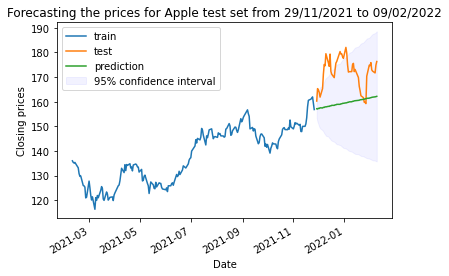

In [13]:
appl = apple[2672:len(apple)]  ### 09/02/2021 to 09/02/2022, 1 year
AutoArima(appl[:int(len(appl)*0.8)],appl[int(len(appl)*0.8):],'Apple')
#plt.title('Predicting stock prices using Auto ARIMA for the Apple test set')

## Apple Auto-arima 6 months

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=464.948, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=466.943, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=468.650, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=470.155, Time=0.10 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=470.070, Time=0.08 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=471.196, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=466.943, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=468.535, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=469.504, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=471.722, Time=0.22 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=471.040, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=468.724, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=469.979, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept

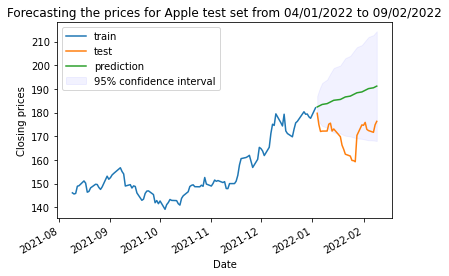

In [14]:
aapl = apple[2797:len(apple)]   ## 09/08/2021 to 09/02/2022 , 6 months
AutoArima(aapl[:int(len(aapl)*0.8)],aapl[int(len(aapl)*0.8):],'Apple') 
#plt.title('Predicting stock prices using Auto ARIMA for the Apple test set')

## Google Auto-arima 1 year

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1998.449, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=2000.448, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=2002.136, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1996.137, Time=0.25 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1996.930, Time=0.34 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1996.432, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=2000.448, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=2002.449, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1998.268, Time=0.35 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1994.978, Time=0.42 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1996.965, Time=0.43 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=2002.173, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=2001.016, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1996.942, Time=0.35 sec
 ARIMA(3,1,0)(0

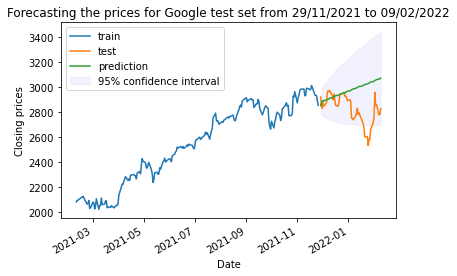

In [15]:
ggle = google[2672:len(google)]
AutoArima(ggle[:int(len(ggle)*0.8)],ggle[int(len(ggle)*0.8):],'Google') 
#plt.title('Predicting stock prices using Auto ARIMA for the Google test set')

## Google Auto-Arima 6 months

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1038.429, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1040.323, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1042.320, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1039.698, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1039.093, Time=0.26 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1041.014, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1040.320, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1039.277, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1040.118, Time=0.23 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1041.071, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1042.290, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1041.205, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1041.830, Time=0.40 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1040.155, Time=0.35 sec
 ARIMA(3,1,0)(0

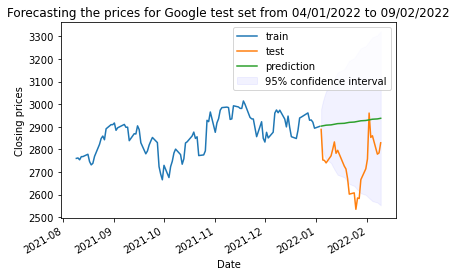

In [16]:
googl =google[2797:len(google)]
AutoArima(googl[:int(len(googl)*0.8)],googl[int(len(googl)*0.8):],'Google') 
#plt.title('Predicting stock prices using Auto ARIMA for the Google test set')

### Check whether the series is stationary using ADF (Augmented Dickey fuller test). If p - value < 0.05, the data is stationary. How do I choose the P value for ADF test? 

In [17]:
def ADF_test(file):
    result = adfuller(file)
    return 'p-value: %f' % result[1]

In [18]:
print('Checking stationarity for 1 year data')
print('Tesla', ADF_test(max_tesla['Close'][2674:len(max_tesla)]))
print('Google', ADF_test(google['Close'][2674:len(google)]))
print('Apple',ADF_test(apple['Close'][2674:len(apple)]))

print('Checking stationarity for 6 months data')
print('Tesla', ADF_test(max_tesla['Close'][2799:len(max_tesla)]))
print('Google', ADF_test(google['Close'][2799:len(google)]))
print('Apple',  ADF_test(apple['Close'][2799:len(apple)]))

Checking stationarity for 1 year data
Tesla p-value: 0.634052
Google p-value: 0.522430
Apple p-value: 0.919318
Checking stationarity for 6 months data
Tesla p-value: 0.440094
Google p-value: 0.030091
Apple p-value: 0.791187


## Arima

def Arima(train,test, p, d, q):
    model = ARIMA(train['Close'], order = (p,d,q)).fit()
    forecast = model.predict(start = len(train), end = (len(train) + len(test))-1)
    plt.plot(test.index[0:50], forecast[0:50])
    plt.show()
    plt.plot(test.index, forecast)
    plt.plot(train['Close'], label = 'train')
    plt.plot(test['Close'], label = 'test')
    plt.show()
    predicted_data = pd.DataFrame({'Date':test.index, 'Close':forecast})
    #print(predicted_data)
    #plt.legend()
    return None

In [19]:
## 1,2,1 and 1,2,2 ARIMA Model
## possible error : make sure the dates are NOT strings which could throw an error
## if there are missing dates in the data the model.predict does not work

#residuals = pd.DataFrame(model_fit.resid)
#residuals.plot()
#residuals.plot(kind= 'kde')
#plt.show()
#print(residuals.describe())

def Arima(train,test, p, d, q, name):
    model = ARIMA(train['Close'], order = (p,d,q))
    model_fit = model.fit()
    fc,stderr,conf_int = model_fit.forecast(len(test),alpha=0.05)
    
    train['Close'].plot(label='Train')
    test ['Close'].plot(label='Test')
    plt.plot(test.index, fc, label = 'Pediction')
    #plt.plot(test.index, conf_int)
    
    conf_int_lower = []
    conf_int_upper = []
    for i in range(0,len(conf_int)):
        conf_int_lower.append(conf_int[i][0])
        conf_int_upper.append(conf_int[i][1])
        
    plt.fill_between(test.index, conf_int_upper, conf_int_lower, color='blue', alpha=0.05, label = '95% confidence interval')
    #predicted_data = pd.DataFrame({'Date':test.index, 'Close':fc})
    plt.title('Forecasting the prices for {} test set from {} to 09/02/2022'. format(name,test.index[0].strftime('%d/%m/%Y')))
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
    return None

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

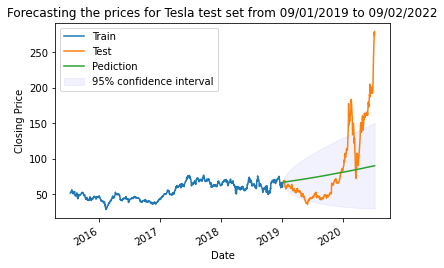

In [20]:
Arima(tesla[:int(len(tesla)*0.7)],tesla[int(len(tesla)*0.7):],1,2,1,'Tesla')
#datetime.strptime(test.index[0].strftime('%Y-%m-%d'), "%Y/%m/%d").strftime('%d/%m/%Y')))

    model = ARIMA(train['Close'], order = (p,d,q))
    model_fit = model.fit()
    fc,stderr,conf_int = model_fit.forecast(len(test),alpha=0.05)
    
    train['Close'].plot(label='Train')
    test ['Close'].plot(label='Test')
    plt.plot(test.index, fc)
    plt.plot(test.index, conf_int)
    
    #predicted_data = pd.DataFrame({'Date':test.index, 'Close':fc})
    plt.show()
    
def final_Arima(data,pdq,d):
    model = ARIMA(data, order = pdq).fit()
    prediction = model.predict(start = len(data), end = len(data) + d, freq = 'D')
    pred_dates = pd.date_range(start = data.index[len(data)-1],  end = data.index[len(data)-1] + timedelta(days = d),freq='D')
    data.plot()
    plt.plot(pred_dates, prediction)
    dataframe = pd.DataFrame({'Date':pred_dates, 'Close':prediction})
    print(dataframe)
    residuals = pd.DataFrame(model.resid)
    residuals.plot()
    plt.show()
    residuals.plot(kind= 'kde')
    plt.show()
    print(residuals.describe())
    
    
    
    
    return None

In [21]:
## This Arima predicts future Stock prices
def final_Arima(data,pdq,d):
    pred_dates = pd.date_range(start = data.index[len(data)-1],  end = data.index[len(data)-1] + timedelta(days = d),freq='D')
    model = ARIMA(data, order = pdq)
    model_fit = model.fit()
    fc,stderr,conf_int = model_fit.forecast(d+1,alpha=0.05)
    
    plt.plot(pred_dates, fc)
    plt.plot(pred_dates, conf_int)
    data.plot()
    #predicted_data = pd.DataFrame({'Date':test.index, 'Close':fc})
    plt.show()
    
    
    return None

## Reproduce reference [3]

In [22]:
def iterating_arima(train_data, test_data, name, p, d, q):
    #train_data, test_data = tesla[0:int(len(tesla)*0.7)], tesla[int(len(tesla)*0.7):]
    training_data = train_data['Close'].values

    test_data = test_data['Close']
    history = [x for x in training_data]

    model_predictions = []
    conf_int_lower    = []
    conf_int_upper    = []
    N_test_observations = len(test_data)


    for time_point in range(N_test_observations):
        model = ARIMA(history, order=(p,d,q)).fit()
        output= model.forecast(alpha=0.05)
        conf_int_upper.append(output[2][0][1])
        conf_int_lower.append(output[2][0][0])
        yhat = output[0][0]
        model_predictions.append(yhat)
        true_test_value = test_data[time_point]
        history.append(true_test_value)
    MSE_error = np.sqrt(mean_squared_error(test_data, model_predictions))
    print('Testing Mean Squared Error is {}'.format(MSE_error))
    
    plt.title('Forecasting the prices for {} test set from {} to 09/02/2022'. format(name,test_data.index[0].strftime('%d/%m/%Y')))
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.fill_between(test_data.index, conf_int_upper, conf_int_lower, color='b', alpha=0.05, label = '95% confidence interval')
    plt.plot(test_data.index, model_predictions, label = 'Prediction')
    train_data['Close'].plot(label= 'train')
    test_data.plot(label='test')
    plt.legend()
    
    return None

## Tesla 1 year iterating ARIMA

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Testing Mean Squared Error is 44.95219468845583


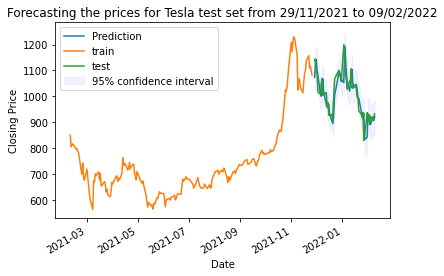

In [23]:
iterating_arima(cut_max_tsla[:int(len(cut_max_tsla)*0.8)], cut_max_tsla[int(len(cut_max_tsla)*0.8):], 'Tesla', 4,0,0)

## Tesla 6 months iterating ARIMA

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Testing Mean Squared Error is 42.06611848337963


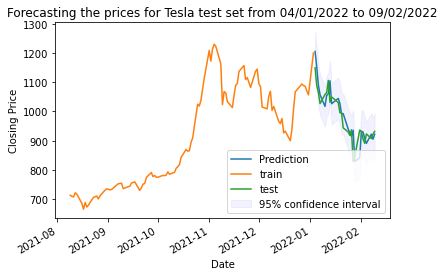

In [24]:
iterating_arima(six_month[:int(len(six_month)*0.8)], six_month[int(len(six_month)*0.8):], 'Tesla',4,0,0)

## Google 1 year iterating ARIMA

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Testing Mean Squared Error is 55.89130339405585


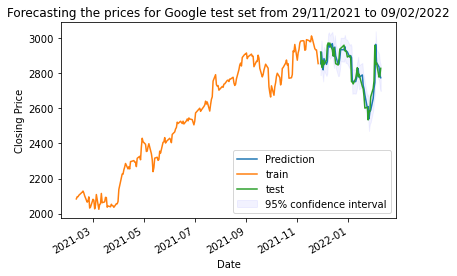

In [25]:
iterating_arima(ggle[0:int(len(ggle)*0.8)], ggle[int(len(ggle)*0.8):], 'Google',4,0,0)

## Google 6 months iterating ARIMA

In [47]:
iterating_arima(googl[0:int(len(googl)*0.8)], googl[int(len(googl)*0.8):], 'Google', 4,0,0)

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Testing Mean Squared Error is 66.05215411318152


## Apple 1 year iterating ARIMA

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:657: RuntimeWarning: overflow encountered in tanh
  newparams = np.tanh(params/2)
C:\Users\

Testing Mean Squared Error is 3.9965231324182793


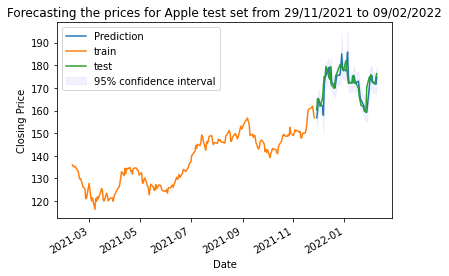

In [49]:
iterating_arima(appl[0:int(len(appl)*0.8)], appl[int(len(appl)*0.8):], 'Apple',4,0,0)

## Apple 6 months iterating ARIMA

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Testing Mean Squared Error is 3.100537000696784


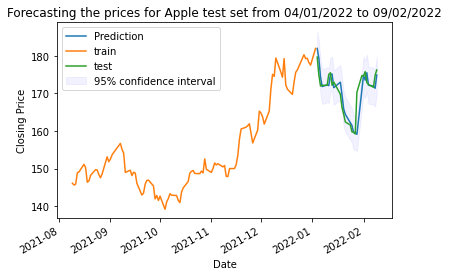

In [50]:
iterating_arima(aapl[0:int(len(aapl)*0.8)], aapl[int(len(aapl)*0.8):], 'Apple',4,0,0)

## How are the p, d, q parameters determined?

d is the order of differencing meaning the number of times the series needs to be differenced to make it stationary. d is determined from the ACF plot. The right order of differencing is the minimum number of times the series has to be differenced to get a near stationary series. The ACF plot of the stationary series should reach 0 fairly quickly. Differencing is ONLY needed if the series is non -stationary. If the series is already stationary then it is not needed which means d=0.

p is determined from the PACF plot. This depends on the number of significant spikes the PACF plot has, for example if the PACF has two significant spikes then p = 2. The blue region in the PACF plot is known as the significance threshold; the spikes that cross the blue region are the significant spikes. 

q = if PACF has a few significant spikes at the beginning and reaches 0 in the middle region and at the same time if ACF has 1 or 2 significant spikes, q is set to the number of significant spikes the ACF plot has.

Since the data is not stationary, compute d (the order of differencing), by plotting the ACF. The order of differencing is the number of times the data is differenced to make it stationary. 

In [30]:
def acf_pacf(d, lag, name,year):
    ##plot the 1st differencing
    first = d.diff()[1:]
    print(first)
    #run this with new data to prevent the nan problem, some data may or may not have the first value as 0
    #(1st val being 0 causes problem)
    plt.plot(first)
    plt.xlabel('Date')
    plt.ylabel('First difference')
    plt.title('First differenced series of {} {}'.format(name, year))
    plt.show()
    
    ##ACF plot of 1st differencing
    plot_acf(first)
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.title('ACF plot of first differenced {} series {}'. format(name,year))
    plt.show()
    
    ##pacf plot of the first differencing
    plot_pacf(first, method = 'ols')
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    plt.title('PACF plot of first differenced {} series {}'. format(name, year))
    plt.show()
    return first

#p=2, d=1, q=20
#p=3, d=1, q=20

## 1 year data 
print('-------------------tesla--------------')
acf_pacf(cut_max_tsla['Close'],2,'Tesla', '(1 year)')
print('-------------------Google--------------')
acf_pacf(ggle['Close'],2, 'Google','(1 year)')
print('-------------------Apple--------------')
acf_pacf(appl['Close'],2, 'Apple','(1 year)')

Date
2021-02-10   -44.640015
2021-02-11     6.839966
2021-02-12     4.460022
2021-02-16   -19.900024
2021-02-17     1.930053
                ...    
2022-02-03   -14.519958
2022-02-04    32.179992
2022-02-07   -15.979980
2022-02-08    14.659973
2022-02-09    10.000000
Name: Close, Length: 253, dtype: float64


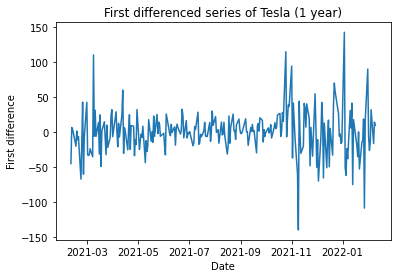

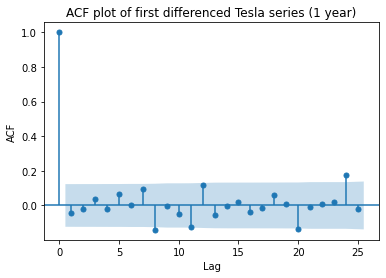

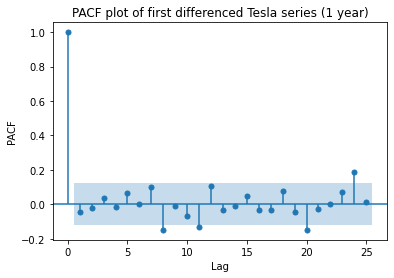

Tesla p-value: 0.000000
Date
2021-02-10     11.869873
2021-02-11      0.510010
2021-02-12      8.220214
2021-02-16     17.789795
2021-02-17      6.410157
                 ...    
2022-02-03   -107.719970
2022-02-04      7.310058
2022-02-07    -81.560058
2022-02-08      5.500000
2022-02-09     44.800049
Name: Close, Length: 253, dtype: float64


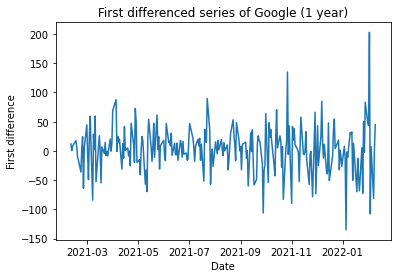

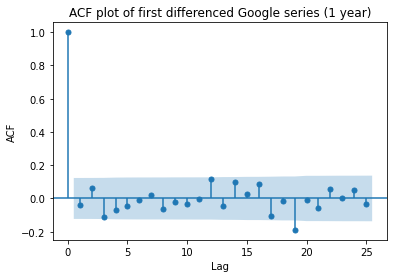

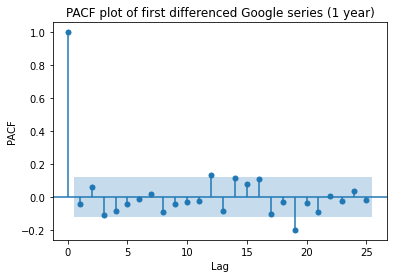

Google p-value: 0.000000
Date
2021-02-10   -0.619996
2021-02-11   -0.259994
2021-02-12    0.239990
2021-02-16   -2.179993
2021-02-17   -2.350006
                ...   
2022-02-03   -2.940002
2022-02-04   -0.509995
2022-02-07   -0.729995
2022-02-08    3.169998
2022-02-09    1.449997
Name: Close, Length: 253, dtype: float64


Apple p-value: 0.000000


In [31]:
print('Tesla', ADF_test(acf_pacf(cut_max_tsla['Close'],2, 'Tesla', '(1 year)')))
print('Google', ADF_test(acf_pacf(ggle['Close'],2, 'Google','(1 year)')))
print('Apple', ADF_test(acf_pacf(appl['Close'],2, 'Apple','(1 year)')))

Date
2021-08-10    -3.770020
2021-08-11    -2.169983
2021-08-12    14.429993
2021-08-13    -5.080017
2021-08-16   -31.000000
                ...    
2022-02-03   -14.519958
2022-02-04    32.179992
2022-02-07   -15.979980
2022-02-08    14.659973
2022-02-09    10.000000
Name: Close, Length: 128, dtype: float64


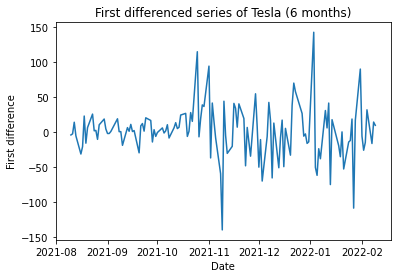

Tesla p-value: 0.000000
Date
2021-08-10      1.889893
2021-08-11     -8.139893
2021-08-12     14.000000
2021-08-13      0.330078
2021-08-16     10.199951
                 ...    
2022-02-03   -107.719970
2022-02-04      7.310058
2022-02-07    -81.560058
2022-02-08      5.500000
2022-02-09     44.800049
Name: Close, Length: 128, dtype: float64


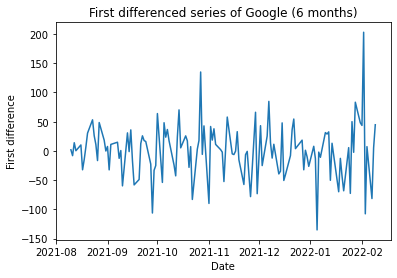

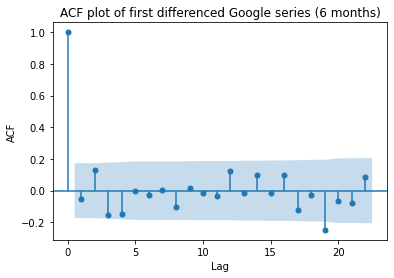

Google Date
2021-08-10      1.889893
2021-08-11     -8.139893
2021-08-12     14.000000
2021-08-13      0.330078
2021-08-16     10.199951
                 ...    
2022-02-03   -107.719970
2022-02-04      7.310058
2022-02-07    -81.560058
2022-02-08      5.500000
2022-02-09     44.800049
Name: Close, Length: 128, dtype: float64
Date
2021-08-10   -0.489990
2021-08-11    0.259995
2021-08-12    3.029998
2021-08-13    0.210007
2021-08-16    2.019989
                ...   
2022-02-03   -2.940002
2022-02-04   -0.509995
2022-02-07   -0.729995
2022-02-08    3.169998
2022-02-09    1.449997
Name: Close, Length: 128, dtype: float64


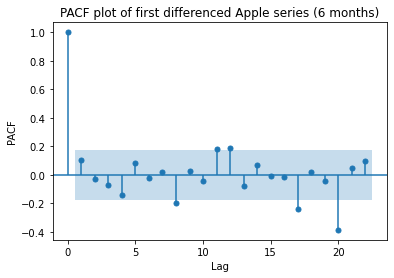

Apple p-value: 0.000000


In [32]:
## 6 months data
print('Tesla', ADF_test(acf_pacf(six_month['Close'],2, 'Tesla','(6 months)')))
print('Google', acf_pacf(googl['Close'],2, 'Google','(6 months)'))
print('Apple', ADF_test(acf_pacf(aapl['Close'],2, 'Apple','(6 months)')))

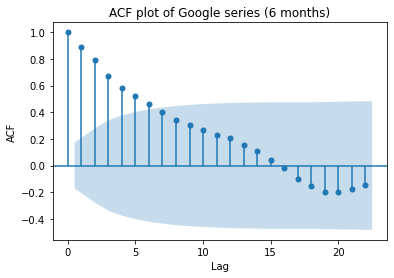

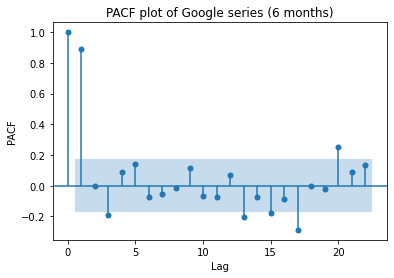

Text(0.5, 1.0, 'Google plot for 6 months data (no differencing required)')

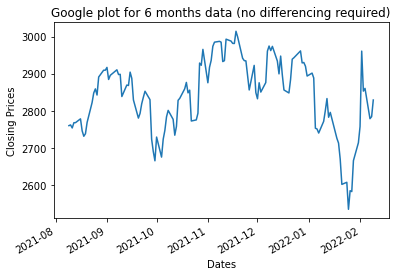

In [33]:
plot_acf(googl['Close'])
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('ACF plot of Google series (6 months)')
plt.show()
    
##pacf plot of the first differencing
plot_pacf(googl['Close'],method = 'ols')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('PACF plot of Google series (6 months)')
plt.show()

googl['Close'].plot()
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.title('Google plot for 6 months data (no differencing required)')

## Tesla 1 year ARIMA

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

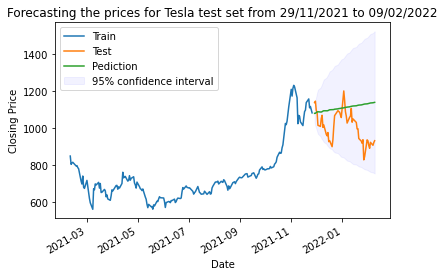

In [34]:
Arima(cut_max_tsla[:int(len(cut_max_tsla)*0.8)],cut_max_tsla[int(len(cut_max_tsla)*0.8):],3,1,2, 'Tesla')

## Tesla 6 months ARIMA

In [35]:
Arima(six_month[:int(len(six_month)*0.8)],six_month[int(len(six_month)*0.8):],1,1,0,'Tesla')

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

## Google 1 year ARIMA

In [31]:
Arima(ggle[:int(len(ggle)*0.8)],ggle[int(len(ggle)*0.8):],1,1,1,'Google') 

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

## Google 6 months ARIMA

In [39]:
Arima(googl[:int(len(googl)*0.8)],googl[int(len(googl)*0.8):],4,0,0, 'Google') 

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

## Apple 1 year ARIMA

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

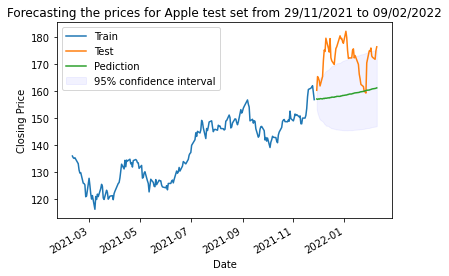

In [37]:
Arima(appl[:int(len(appl)*0.8)],appl[int(len(appl)*0.8):],2,1,2,'Apple')

## Apple 6 months ARIMA

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

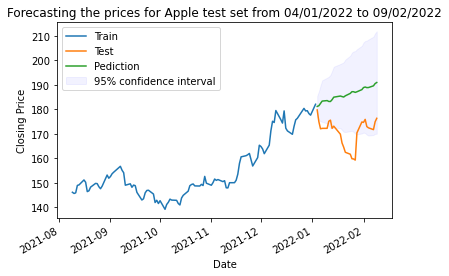

In [38]:
Arima(aapl[:int(len(aapl)*0.8)],aapl[int(len(aapl)*0.8):],3,1,2,'Apple') 

### Grid search pdq

In [35]:
import itertools

In [95]:
def grid_search(file, train, test, name):
    p= range(0,4)
    d=range(1,2)
    q= range(0,6)
    param_combo = list(itertools.product(p,d,q))
    
    AIC = []
    order1=[]
    
    
    for param in param_combo:
        try:
            model =  ARIMA(train['Close'], order=param).fit()
            predict = model.forecast(len(test))
            AIC.append(model.aic)
            order1.append(param)
        except:
            continue
   
    result = pd.DataFrame({'(p,d,q)': order1, 'AIC' :AIC})
    
    print('minimum AIC:',min(AIC))
    min_index = AIC.index(min(AIC))
    order = order1[min_index]
    print('The order with minimum AIC is:', order1[min_index])
    
    Arima(train, test, order[0],order[1],order[2],name)
    return result


## Tesla 1 year grid search 

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

minimum AIC: 1897.7330022131587
The order with minimum AIC is: (2, 1, 2)


C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


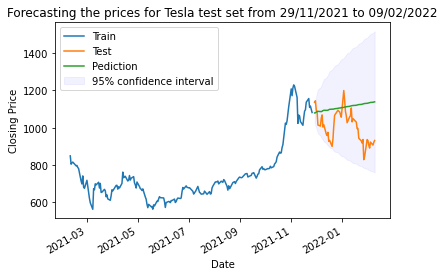

(p,d,q)          AIC
0   (0, 1, 0)  1900.021776
1   (0, 1, 1)  1901.921452
2   (0, 1, 2)  1903.292312
3   (0, 1, 3)  1902.563045
4   (0, 1, 4)  1904.480777
5   (0, 1, 5)  1906.472652
6   (1, 1, 0)  1901.910723
7   (1, 1, 1)  1903.854037
8   (1, 1, 2)  1903.980225
9   (1, 1, 3)  1904.496920
10  (1, 1, 4)  1906.479830
11  (1, 1, 5)  1908.386961
12  (2, 1, 0)  1903.398610
13  (2, 1, 1)  1904.349726
14  (2, 1, 2)  1897.733002
15  (2, 1, 3)  1899.707320
16  (2, 1, 4)  1901.656759
17  (2, 1, 5)  1903.684878
18  (3, 1, 0)  1903.058799
19  (3, 1, 1)  1905.018552
20  (3, 1, 2)  1899.706323
21  (3, 1, 3)  1907.190314
22  (3, 1, 4)  1903.595654
23  (3, 1, 5)  1909.272621

In [97]:
grid_search(cut_max_tsla, cut_max_tsla[:int(len(cut_max_tsla)*0.8)], cut_max_tsla[int(len(cut_max_tsla)*0.8):], 'Tesla')

## Tesla 6 months grid search

In [98]:
grid_search(six_month, six_month[:int(len(six_month)*0.8)], six_month[int(len(six_month)*0.8):], 'Tesla')

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

minimum AIC: 1019.6463226603636
The order with minimum AIC is: (0, 1, 0)


C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


(p,d,q)          AIC
0   (0, 1, 0)  1019.646323
1   (0, 1, 1)  1021.292376
2   (0, 1, 2)  1023.174724
3   (0, 1, 3)  1025.152914
4   (0, 1, 4)  1026.058122
5   (0, 1, 5)  1023.241783
6   (1, 1, 0)  1021.269190
7   (1, 1, 1)  1023.161560
8   (1, 1, 2)  1025.171728
9   (1, 1, 3)  1024.084135
10  (1, 1, 4)  1024.985673
11  (1, 1, 5)  1024.577482
12  (2, 1, 0)  1023.180631
13  (2, 1, 1)  1025.160441
14  (2, 1, 2)  1021.839772
15  (2, 1, 4)  1023.734750
16  (2, 1, 5)  1024.770148
17  (3, 1, 0)  1025.162539
18  (3, 1, 1)  1023.591596
19  (3, 1, 2)  1022.990083
20  (3, 1, 3)  1021.991076
21  (3, 1, 4)  1021.757871
22  (3, 1, 5)  1025.850748

## Google 1 year grid search

In [99]:
grid_search(ggle, ggle[:int(len(ggle)*0.8)], ggle[int(len(ggle)*0.8):], 'Google')

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

minimum AIC: 1994.9832784308528
The order with minimum AIC is: (1, 1, 3)


C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


(p,d,q)          AIC
0   (0, 1, 0)  1998.449012
1   (0, 1, 1)  2000.447907
2   (0, 1, 2)  2002.134710
3   (0, 1, 3)  1996.139045
4   (0, 1, 4)  1996.935584
5   (0, 1, 5)  1996.444244
6   (1, 1, 0)  2000.447991
7   (1, 1, 1)  2002.570205
8   (1, 1, 2)  1999.772272
9   (1, 1, 3)  1994.983278
10  (1, 1, 4)  1996.970081
11  (1, 1, 5)  1997.891276
12  (2, 1, 0)  2002.173613
13  (2, 1, 1)  1999.771185
14  (2, 1, 2)  2001.770947
15  (2, 1, 3)  1996.944963
16  (2, 1, 4)  1996.374663
17  (2, 1, 5)  1999.470828
18  (3, 1, 0)  1996.280435
19  (3, 1, 1)  1996.558153
20  (3, 1, 2)  1996.909509
21  (3, 1, 3)  1997.830815
22  (3, 1, 4)  1998.262580
23  (3, 1, 5)  1998.742492

## Google 6 months grid search

In [100]:
grid_search(googl, googl[:int(len(googl)*0.8)], googl[int(len(googl)*0.8):], 'Google')

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

minimum AIC: 1037.853783832038
The order with minimum AIC is: (2, 1, 2)


C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


(p,d,q)          AIC
0   (0, 1, 0)  1038.428847
1   (0, 1, 1)  1040.322539
2   (0, 1, 2)  1042.319433
3   (0, 1, 3)  1039.690917
4   (0, 1, 4)  1039.076015
5   (0, 1, 5)  1040.992375
6   (1, 1, 0)  1040.320221
7   (1, 1, 1)  1039.296867
8   (1, 1, 2)  1041.216169
9   (1, 1, 3)  1040.100820
10  (1, 1, 4)  1041.052095
11  (1, 1, 5)  1042.040388
12  (2, 1, 0)  1042.288743
13  (2, 1, 1)  1041.222849
14  (2, 1, 2)  1037.853784
15  (2, 1, 3)  1040.136889
16  (2, 1, 4)  1041.595040
17  (2, 1, 5)  1040.683520
18  (3, 1, 0)  1039.266197
19  (3, 1, 1)  1039.383836
20  (3, 1, 2)  1041.039833
21  (3, 1, 3)  1038.087603
22  (3, 1, 4)  1040.036354
23  (3, 1, 5)  1042.636430

## Apple 1 year grid search

In [101]:
grid_search(appl, appl[:int(len(appl)*0.8)], appl[int(len(appl)*0.8):], 'Apple')

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

minimum AIC: 846.3392675702297
The order with minimum AIC is: (3, 1, 3)


C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


(p,d,q)         AIC
0   (0, 1, 0)  849.328814
1   (0, 1, 1)  850.755623
2   (0, 1, 2)  852.747915
3   (0, 1, 3)  853.210993
4   (0, 1, 4)  849.922753
5   (0, 1, 5)  851.156689
6   (1, 1, 0)  850.759334
7   (1, 1, 1)  851.228389
8   (1, 1, 2)  853.009650
9   (1, 1, 3)  849.096288
10  (1, 1, 4)  849.927155
11  (1, 1, 5)  851.924574
12  (2, 1, 0)  852.759151
13  (2, 1, 1)  853.001627
14  (2, 1, 2)  849.777824
15  (2, 1, 3)  848.745802
16  (2, 1, 4)  851.684211
17  (2, 1, 5)  852.152403
18  (3, 1, 0)  852.323261
19  (3, 1, 1)  848.976102
20  (3, 1, 2)  848.846423
21  (3, 1, 3)  846.339268
22  (3, 1, 4)  852.160980
23  (3, 1, 5)  855.906081

## Apple 6 months grid search

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

minimum AIC: 464.9482317426071
The order with minimum AIC is: (0, 1, 0)


C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\asfia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


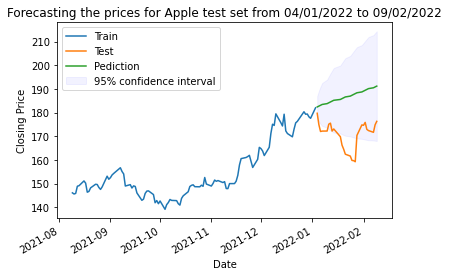

(p,d,q)         AIC
0   (0, 1, 0)  464.948232
1   (0, 1, 1)  466.942729
2   (0, 1, 2)  468.649845
3   (0, 1, 3)  470.155221
4   (0, 1, 4)  470.069696
5   (0, 1, 5)  471.196173
6   (1, 1, 0)  466.943240
7   (1, 1, 1)  467.555933
8   (1, 1, 2)  470.058843
9   (1, 1, 3)  471.721942
10  (1, 1, 4)  471.040433
11  (1, 1, 5)  473.012539
12  (2, 1, 0)  468.724006
13  (2, 1, 1)  469.979108
14  (2, 1, 4)  473.020577
15  (2, 1, 5)  472.047078
16  (3, 1, 0)  470.086372
17  (3, 1, 1)  471.577057
18  (3, 1, 2)  465.550285
19  (3, 1, 3)  466.878707
20  (3, 1, 4)  468.843652
21  (3, 1, 5)  468.765145

In [102]:
grid_search(aapl, aapl[:int(len(aapl)*0.8)], aapl[int(len(aapl)*0.8):], 'Apple')

In [86]:
## 1 year
#cut_max_tsla[:int(len(cut_max_tsla)*0.8)]  ##20% 29/11/2021 - 09/02/2022, 80% 09/02/2021 - 26/11/2021
#ggle[:int(len(ggle)*0.8)]
#appl[:int(len(appl)*0.8)]

##6 month
#six_month[:int(len(six_month)*0.8)] ## 20% 04/01/2022 - 09/02/2022, 80% 09/08/2021 - 03/01/2022
#googl[int(len(googl)*0.8):]
#aapl[:int(len(aapl)*0.8)]

### Reference:
[1] https://uk.finance.yahoo.com/quote/AAPL/history?p=AAPL \
[2] https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/  \
[3] https://towardsdatascience.com/time-series-forecasting-predicting-stock-prices-using-an-arima-model-2e3b3080bd70 \
[4] https://medium.com/@derejeabera/stock-price-prediction-using-arima-model-251ddb4ee52a

In [39]:
#1 year
def plot(data, name, year):
    data['Close'][:int(len(data)*0.8)].plot(label = 'Train')
    data['Close'][int(len(data)*0.8):].plot(label = 'test')
    plt.xlabel('Dates')
    plt.ylabel('Closing prices')
    plt.title('Plot of {} with 80/20 split for {} data set'.format(name, year))
    plt.legend()
    return None


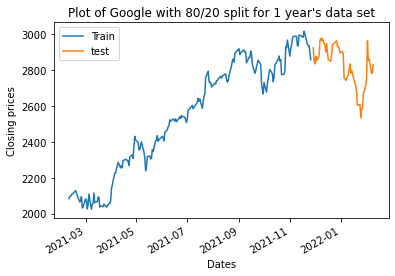

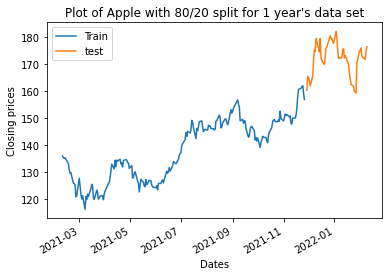

In [42]:
##1 year 
plot(cut_max_tsla, 'Tesla', '1 year\'s')
plt.show()
plot(ggle, 'Google', '1 year\'s' )
plt.show()
plot(appl,'Apple', '1 year\'s')

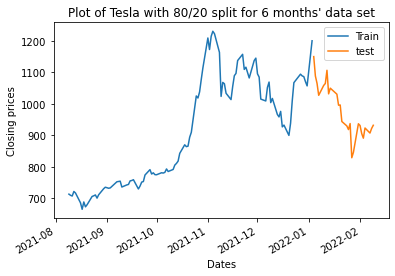

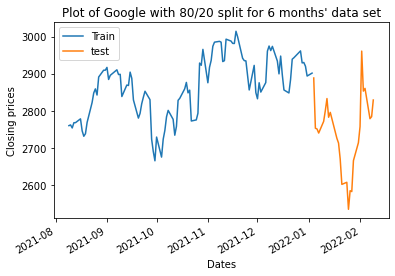

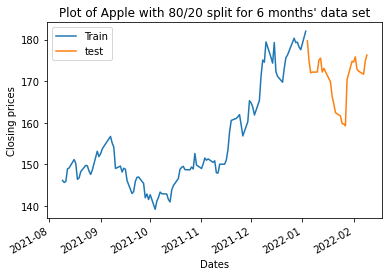

In [45]:
## 6 months
plot(six_month, 'Tesla', '6 months\'')
plt.show()
plot(googl, 'Google', '6 months\'')
plt.show()
plot(aapl, 'Apple', '6 months\'')